# Bigmart Sales Anomaly Detection
In this experiment, we are going to perform outlier detection on Bigmart sales dataset using different PyOD anomaly detection models.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 1. Import
Let's first import all the libraries that is required throughout this journey.

In [2]:
!pip install pyod
!pip install combo

  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42860 sha256=1dbbf6e39b7509a1587addfc7cafea01082cb242bd74afc3f4aa44ff43cafd92
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager


from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from pyod.models.inne import INNE
from pyod.models.gmm import GMM
from pyod.models.kde import KDE
from pyod.models.lmdd import LMDD
from pyod.models.dif import DIF
from pyod.models.copod import COPOD
from pyod.models.ecod import ECOD
from pyod.models.qmcd import QMCD
from pyod.models.sampling import Sampling
from pyod.models.kpca import KPCA
from pyod.models.lunar import LUNAR

%matplotlib inline

## 2. Load the dataset
Here, we are going to load Bigmart sales dataset from Bigmart Sales Prediction competition.

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/Bigmart_Sales/train.csv")

In [5]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

Let's see distribution of MRP

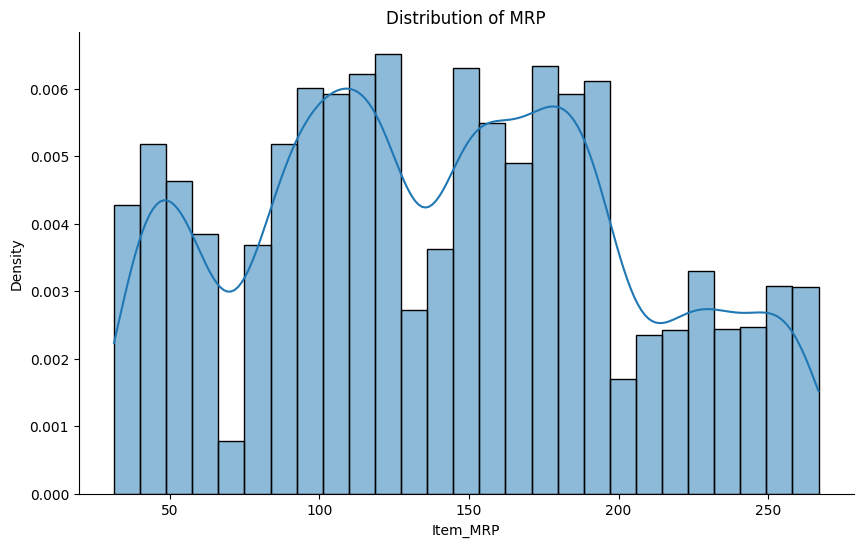

In [7]:
#Create a larger figure
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(df['Item_MRP'], kde=True, stat="density")
plt.title("Distribution of MRP")
sns.despine()

# Show the plot
plt.show()

In [8]:
df['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

Let's check the distribution of another feature called Profit


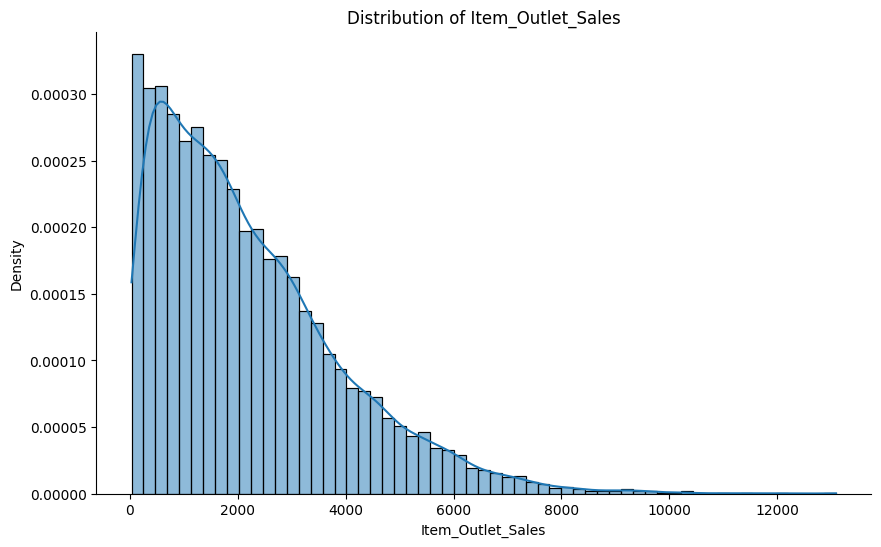

In [9]:
#Create a larger figure
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(df['Item_Outlet_Sales'], kde=True, stat="density")
plt.title("Distribution of Item_Outlet_Sales")
sns.despine()

# Show the plot
plt.show()

The Item_Outlet_Sales distribution is far from a normal distribution, and it has a positive long thin tail, the mass of the distribution is concentrated on the left of the figure. And the tail sales distribution far exceeds the tails of the normal distribution.

There are one region where the data has low probability to appear which is on the right side of the distribution.

In [10]:
df['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

Let's see correlation between `Item_MRP` and `Item_Outlet_Sales`

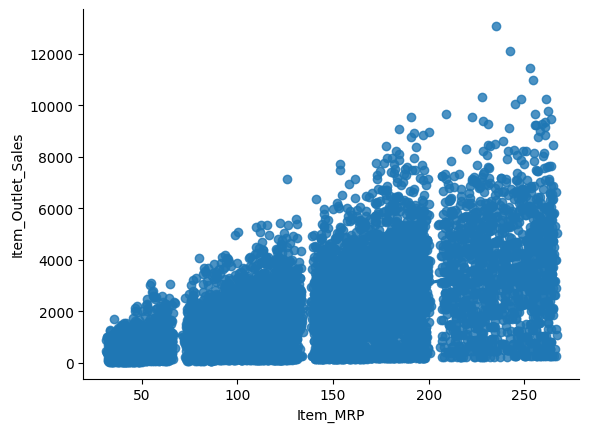

In [11]:
sns.regplot(x="Item_MRP", y="Item_Outlet_Sales", data=df)
sns.despine();

Let’s plot Item MRP(Maximum Retail Price) vs Item Outlet Sales to understand the data:

<Axes: xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

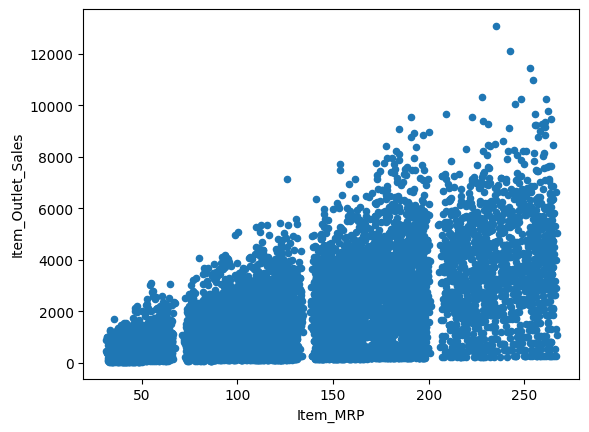

In [12]:
df.plot.scatter('Item_MRP','Item_Outlet_Sales')

The range of Item Outlet Sales is from 0 to 12000 and Item MRP is from 0 to 250. We will scale down both these features to a range between 0 and 1. This is required to create a explainable visualization (it will become way too stretched otherwise).

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = df.copy()
df1[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP','Item_Outlet_Sales']])
df1[['Item_MRP','Item_Outlet_Sales']].head()

,Item_MRP,Item_Outlet_Sales
0,0.927507,0.283587
1,0.072068,0.031419
2,0.468288,0.158115
3,0.640093,0.053555
4,0.095805,0.073651


Concate these two features.

In [14]:
X1 = df1['Item_MRP'].values.reshape(-1,1)
X2 = df1['Item_Outlet_Sales'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

In [15]:
X.shape

(8523, 2)

## 3. Model Instantiation
we will create a dictionary. But this time, we will add some more models to it and see how each model predicts outliers. In our example, I want to detect 5% observations that are not similar to the rest of the data. So, I’m going to set the value of outlier fraction as 0.05.


In [21]:
random_state = 42
outliers_fraction = 0.05

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
             LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
             LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
             LOF(n_neighbors=50)]
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),

    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'Deep Isolation Forest (DIF)': DIF(contamination=outliers_fraction,
                                       random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),

    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),


    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),

    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
}

In [22]:
# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 K Nearest Neighbors (KNN)
Model 3 Average KNN
Model 4 Local Outlier Factor (LOF)
Model 5 Isolation Forest
Model 6 Deep Isolation Forest (DIF)
Model 7 Feature Bagging
Model 8 Principal Component Analysis (PCA)
Model 9 Cluster-based Local Outlier Factor (CBLOF)
Model 10 One-class SVM (OCSVM)


## 4. Model Fitting and Visualization
Now, we will fit the data to each model one by one and see how differently each model predicts the outliers.

OUTLIERS :  447 INLIERS :  8076 Angle-based Outlier Detector (ABOD)


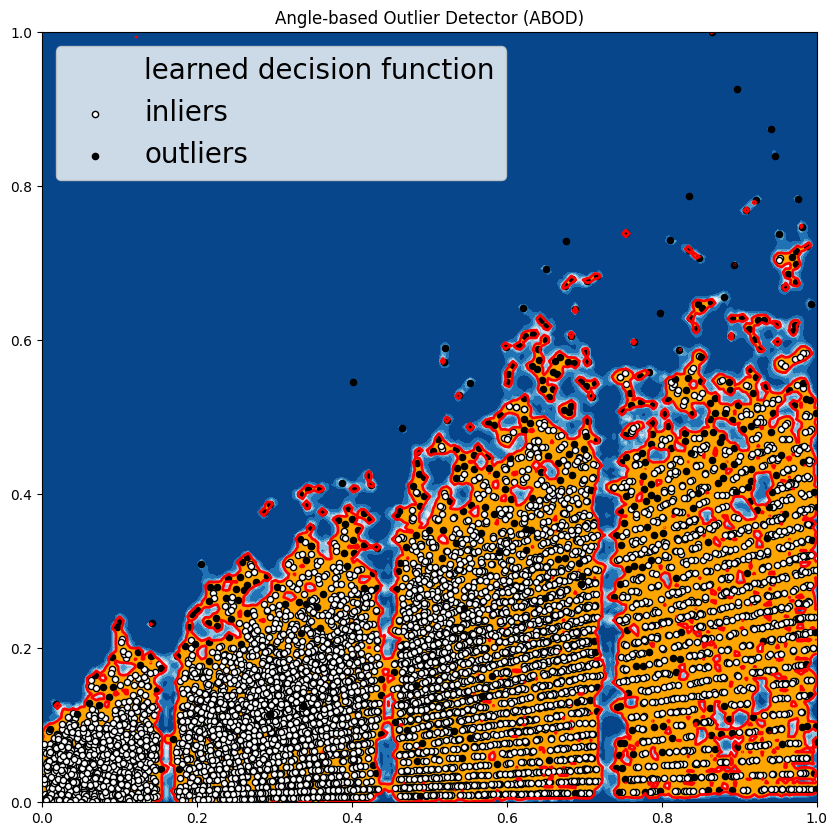

OUTLIERS :  311 INLIERS :  8212 K Nearest Neighbors (KNN)


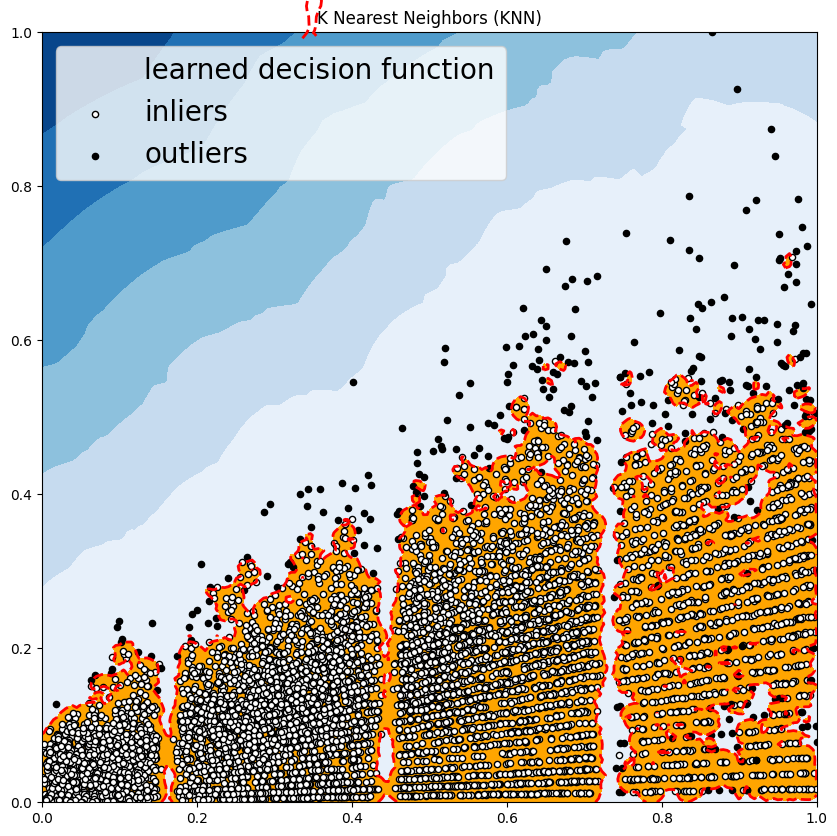

OUTLIERS :  176 INLIERS :  8347 Average KNN


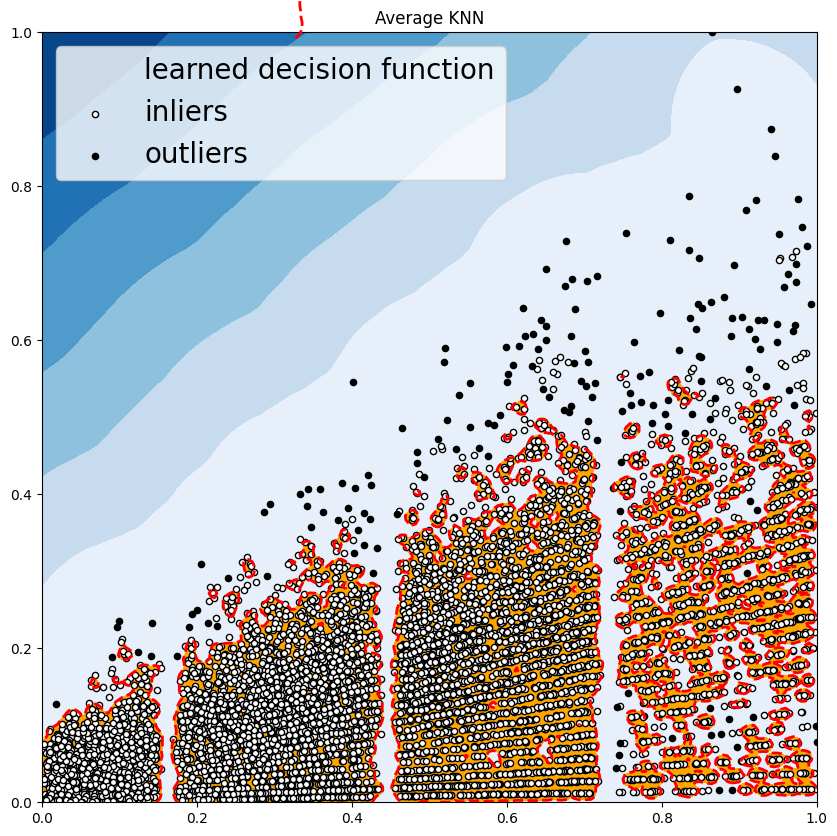

OUTLIERS :  392 INLIERS :  8131 Local Outlier Factor (LOF)


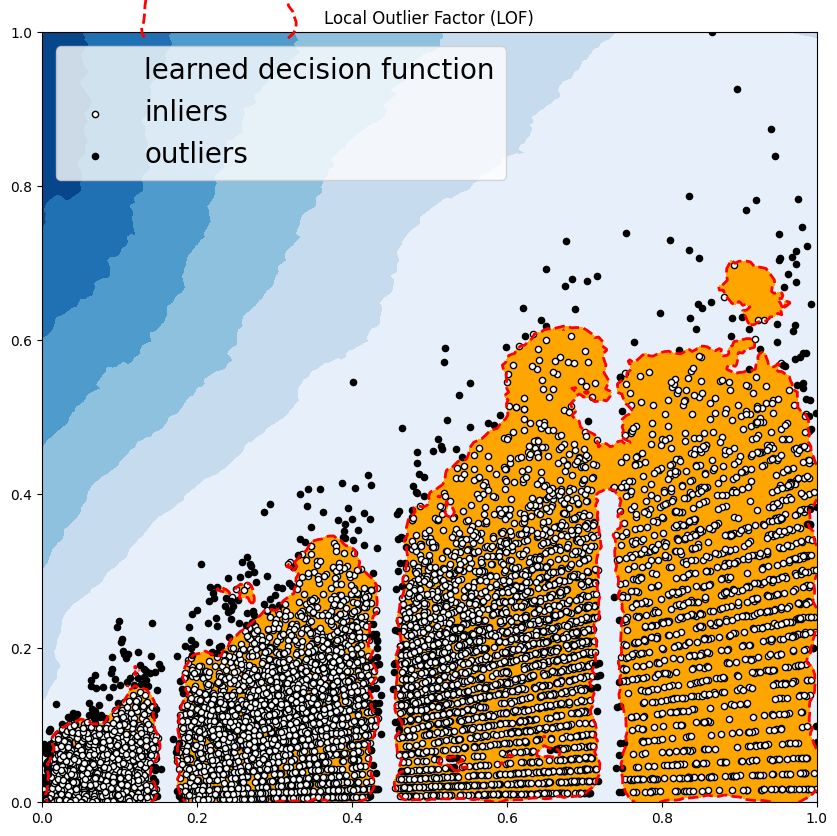

OUTLIERS :  427 INLIERS :  8096 Isolation Forest


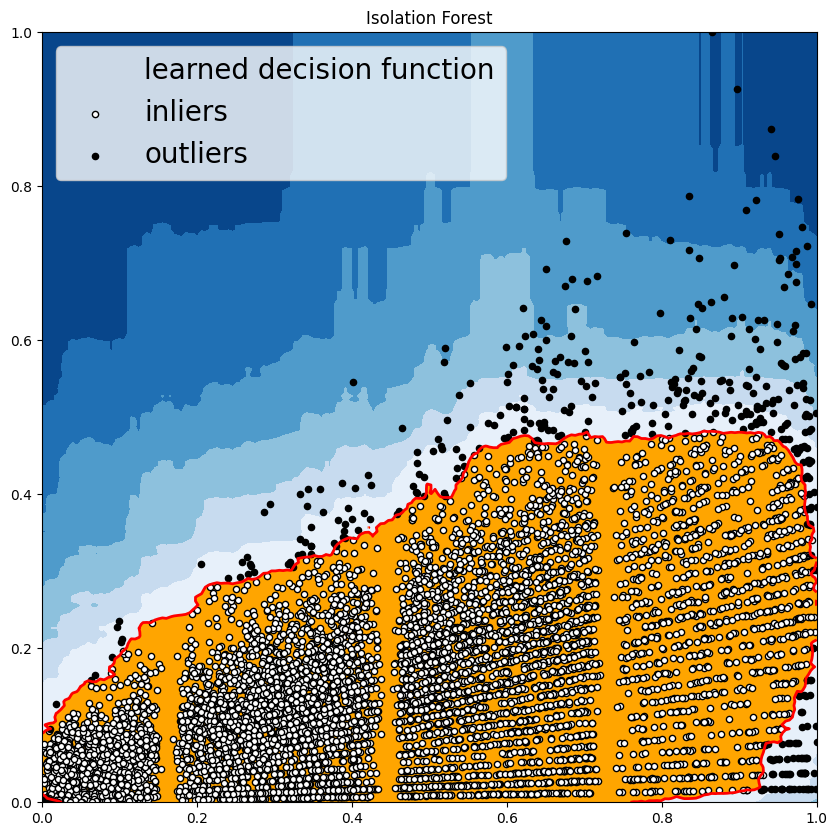

OUTLIERS :  427 INLIERS :  8096 Deep Isolation Forest (DIF)


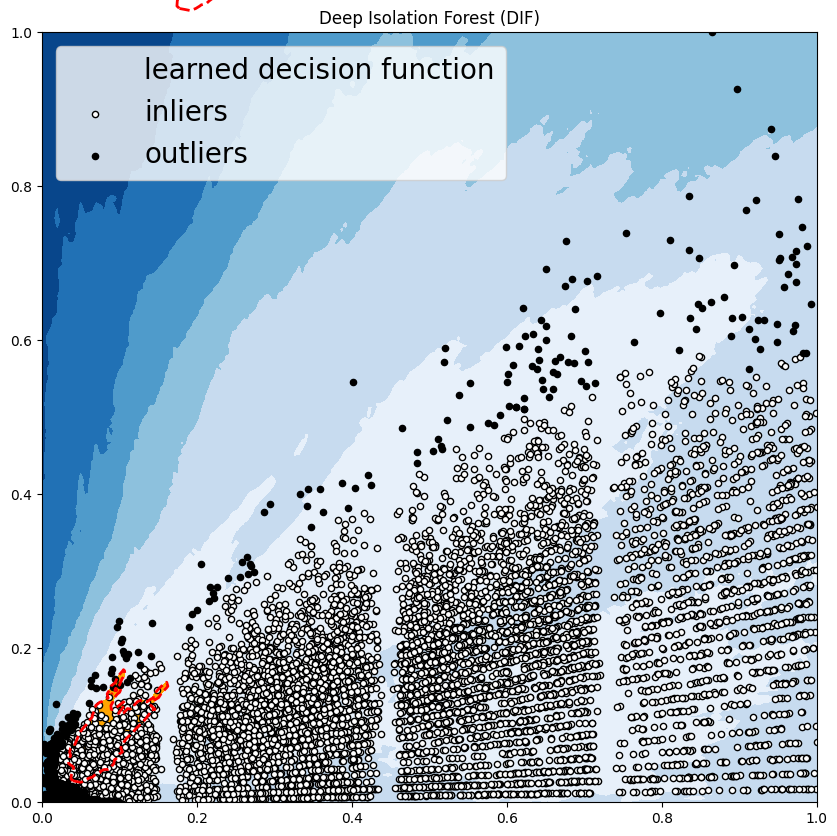

OUTLIERS :  364 INLIERS :  8159 Feature Bagging


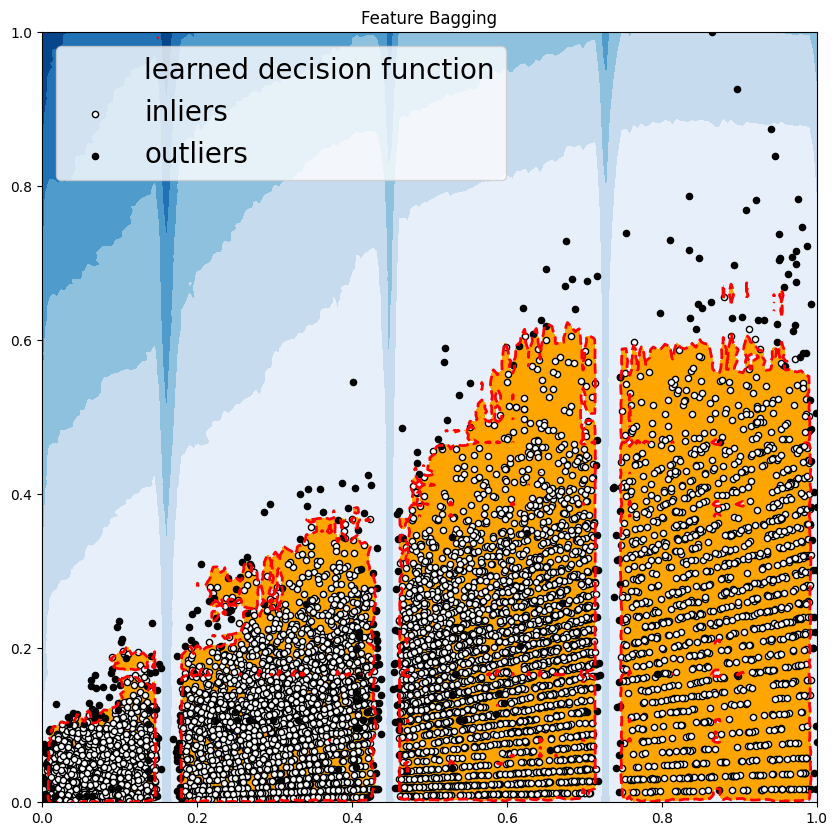

OUTLIERS :  427 INLIERS :  8096 Principal Component Analysis (PCA)


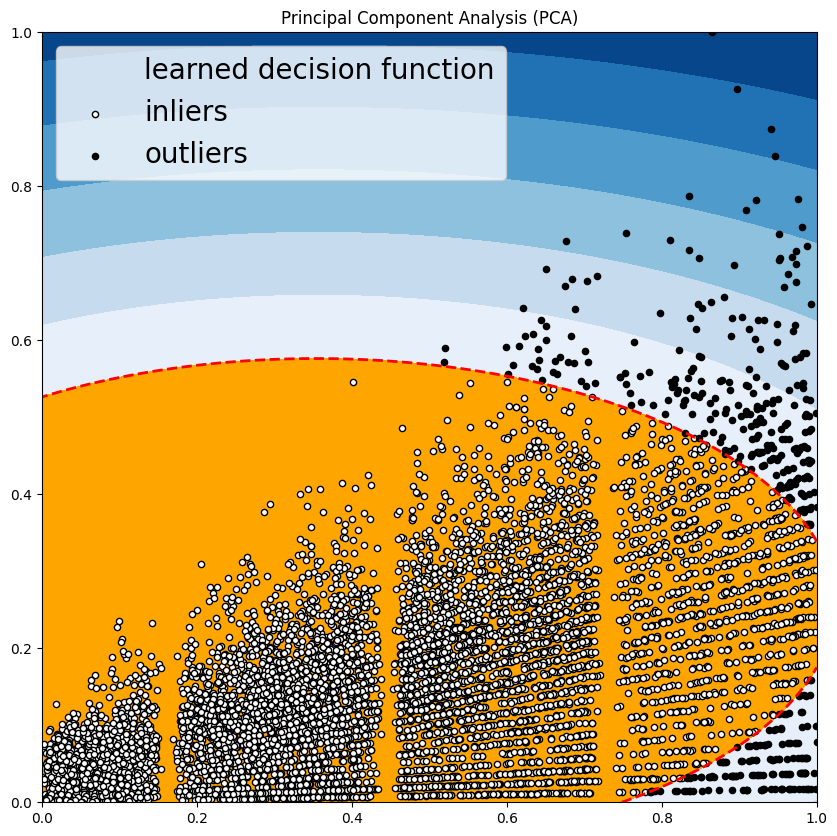

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


OUTLIERS :  427 INLIERS :  8096 Cluster-based Local Outlier Factor (CBLOF)


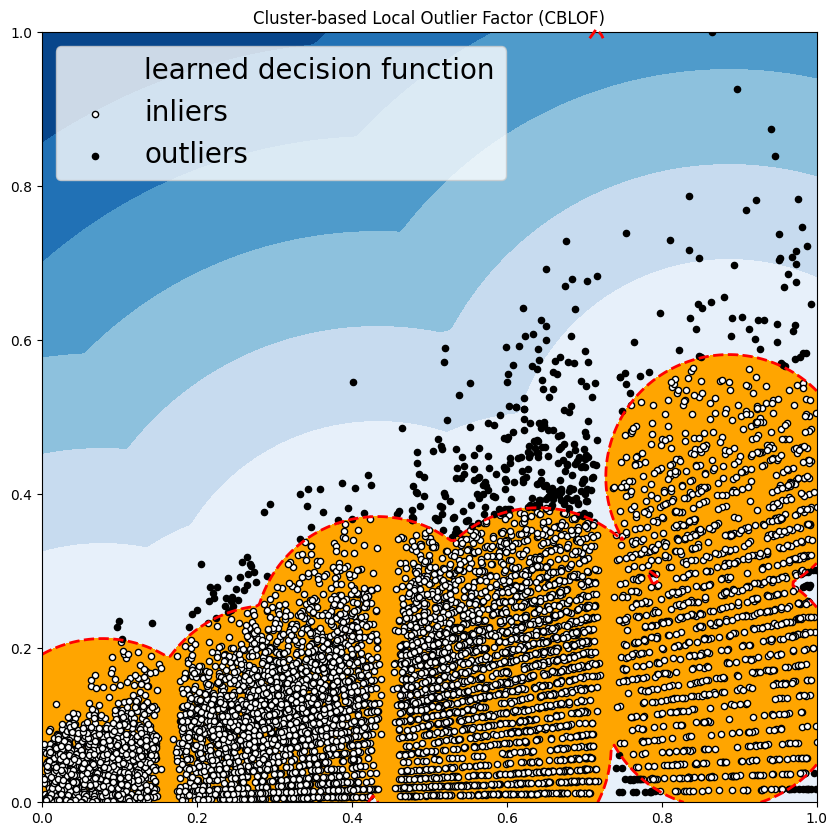

OUTLIERS :  427 INLIERS :  8096 One-class SVM (OCSVM)


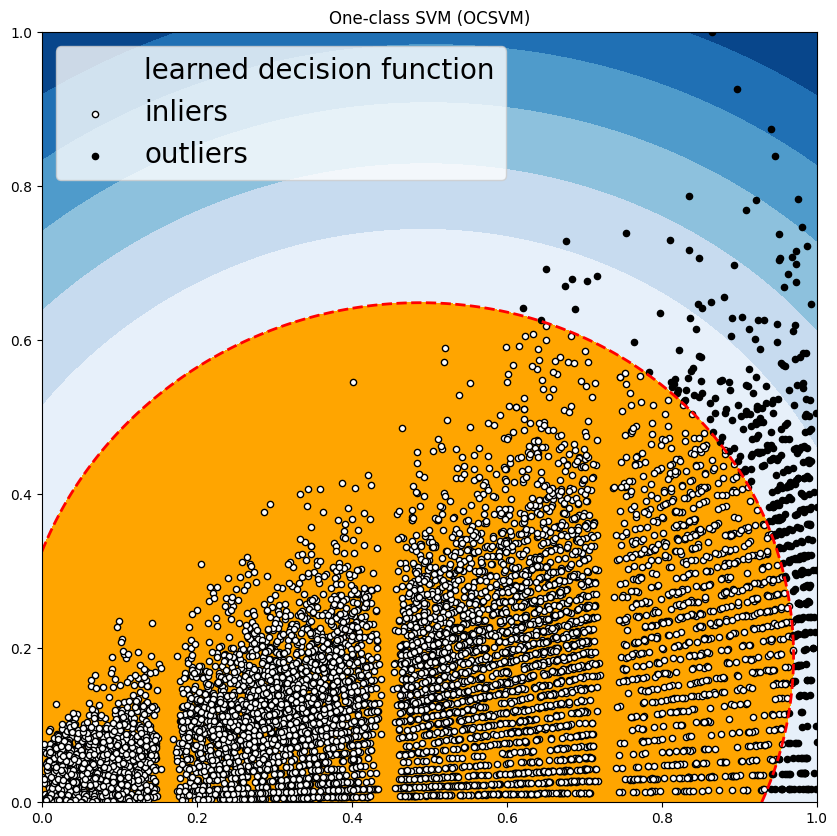

In [23]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))

    # copy of dataframe
    dfx = df1
    dfx['outlier'] = y_pred.tolist()

    In_feat1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    In_feat2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)

    Out_feat1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    Out_feat2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)

    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    b = plt.scatter(In_feat1,In_feat2, c='white',s=20, edgecolor='k')

    c = plt.scatter(Out_feat1,Out_feat2, c='black',s=20, edgecolor='k')

    plt.axis('tight')

    # loc=2 is used for the top left corner
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.savefig(f'./plots/Bigmart_sales_outliers_result_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()

PyOD is such a good tools to detect outliers